<a href="https://colab.research.google.com/github/kavyajeetbora/CityHealthMonitor/blob/master/development/surface_temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import external packages

In [1]:
!pip install -q rioxarray
!pip install -q h3
!pip install -q pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 22.1 MB/s eta 0:00:00


In [2]:
import geemap
import ee
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import Polygon, Point
import h3
from matplotlib import colormaps
import pydeck as pdk

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Utility Functions

- Create a standard function to apply filters on image collection

In [3]:
def filterImageCollection(
        image_collection_id: str,
        geometry: ee.geometry.Geometry,
        date_range: tuple[str]
    ) -> ee.imagecollection.ImageCollection:

    imageCollection = ee.ImageCollection(image_collection_id)
    d1,d2 = date_range
    filtered = imageCollection.filter(
        ee.Filter.date(d1, d2) ## Filter by date
    ).filter(
        ee.Filter.bounds(geometry) ## Filter by bounds
    )

    return filtered

def kelvin_to_celsius(image):
    temp = image.multiply(0.02).subtract(273.15).rename('temp_C')
    return image.addBands(temp).copyProperties(image, ['system:time_start'])

In [4]:
## get the current dates
today = datetime.now()
d1 = today - timedelta(days=30)
current_date_range = (d1.date().strftime('%Y-%m-%d'), today.date().strftime('%Y-%m-%d'))
current_date_range

('2024-03-25', '2024-04-24')

## Visualizing satellite RGB image

In [5]:
admin = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
delhi = admin.filter(ee.Filter.eq('ADM1_NAME', 'Delhi'))\
.filter(ee.Filter.eq('ADM2_NAME', 'Delhi'))

geometry = delhi.geometry()

filtered_imgs = filterImageCollection(
    image_collection_id = 'COPERNICUS/S2_SR_HARMONIZED',
    geometry = geometry,
    date_range = current_date_range
)

In [6]:
image = filtered_imgs.median()
clipped_img = image.clip(geometry)

center = (28.6182,77.2009)
Map = geemap.Map(center=center, zoom=10)
boundary_viz_params = {
    'color':'red',
    "width":2,
    "lineType":"solid",
    'fillColorOpacity': 0.1
}
Map.addLayer(ee_object=delhi, vis_params=boundary_viz_params, name='Delhi Boundary')
viz_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', "B3", "B2"]
}
Map.addLayer(clipped_img, viz_params, name='Sentinel')
Map

Map(center=[28.6182, 77.2009], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

## Visualizing the surface temperature data

In [7]:
## Filtered_image_Collection
surface_temp = filterImageCollection(
        image_collection_id = "MODIS/061/MOD11A1",
        geometry = geometry,
        date_range = current_date_range
    )\
    .select('LST_Day_1km')\
    .map(kelvin_to_celsius)

surface_temp.size()

## Calculate the median composite for plotting

In [8]:
temp_mean = surface_temp.median().clip(geometry)
temp_mean.bandNames()

In [9]:
center = (28.6182,77.2009)
Map = geemap.Map(center=center, zoom=10)
viz_params = {
    'min': 0,
    'max': 50,
    'bands': ['temp_C'],
    'palette': ['#ffffb2','#fecc5c','#fd8d3c','#f03b20','#bd0026']
}
Map.addLayer(temp_mean, viz_params, name='Surface Temperature')
Map

Map(center=[28.6182, 77.2009], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

## Extract the time series data

In [10]:
def summarizeRegion(image, geometry, bandName):
    '''
    Compute the average regional stat of a given image
    and store it in image property metadata
    '''
    stat = ee.Number(image.reduceRegion(
        reducer = ee.Reducer.mean(),
        geometry = geometry,
        scale = 1000, ## scale = 10 m pixel, gee will down/up sample the image as required
        maxPixels = 1e10
    ).get(bandName))

    return image.set('average_stat', stat)


# Get a list of dictionaries containing image information

def extract_time_series(image_collection, stat='average_stat', time_prop_id = 'system:time_start'):
    '''
    Extract timeseries values, the average values and the time
    here time will be converted to python datetime object
    It will set as none where average value is not found
    '''

    image_list = image_collection.getInfo()['features']
    properties = [img['properties'] for img in image_list]

    x, y = [], []
    for prop in tqdm(properties, unit=" data"):
        try:
            stat = prop['average_stat']
            time = prop[time_prop_id]/1000 ## timestamps in seconds
            time = datetime.fromtimestamp(time) #.strftime('%Y-%m-%d')

            y.append(stat)
            x.append(time)

        except Exception as e:
            ## Skip the reading if null value found
            pass

    return x,y

def plot_time_series(x,y, title='Average Surface Temperature'):
    '''
    Plot the time series given the x - datetime, y- stat
    and return a matplotlib figure
    '''

    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(x,y)
    ax.set_xlabel("Date")
    ax.set_ylabel(title)
    ax.set_title(title)
    return fig

In [11]:
## First see calculating the mean of the temperature over the region
stat = summarizeRegion(temp_mean, geometry, 'temp_C')
average_temperature = stat.getInfo()['properties']['average_stat']
average_temperature

33.13953101924447

In [12]:
## Extract the average temperature for each image over the region
time_series_data = surface_temp.map(lambda x: summarizeRegion(x, geometry, 'temp_C'))
x,y = extract_time_series(time_series_data)

  0%|          | 0/22 [00:00<?, ? data/s]

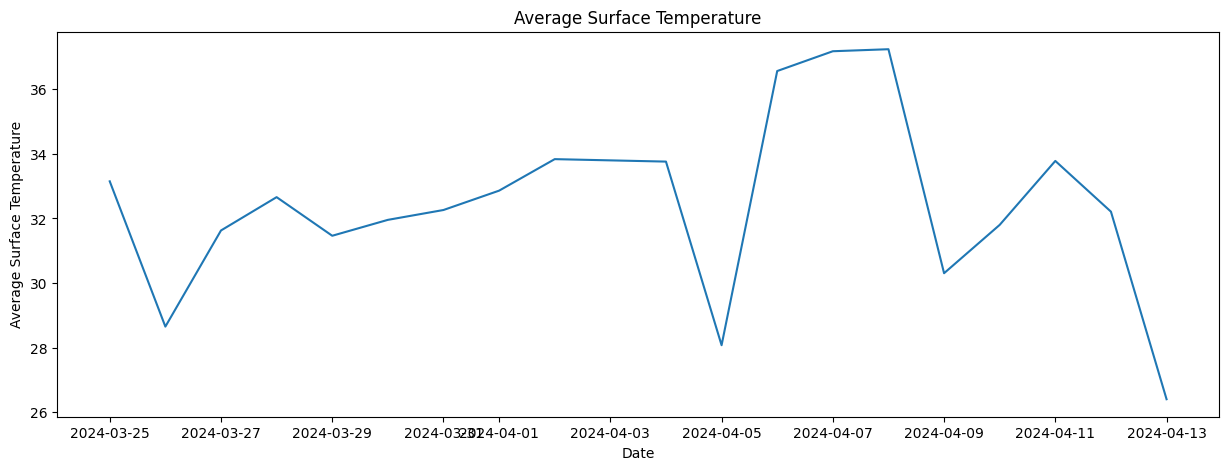

In [13]:
fig = plot_time_series(x,y)
fig.show()

## Export the data

Export the surface temperature raster image:

In [14]:
temp_mean.bandNames()

In [15]:
geemap.ee_export_image(
    temp_mean.clip(geometry),
    filename='surface_temperature.tif',
    scale=100,
    file_per_band=False,
    region=geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /content/surface_temperature.tif


In [16]:
import pandas as pd

df = pd.DataFrame({"datetime":x, "avg_surf_temp":y})
df.head()

,datetime,avg_surf_temp
0,2024-03-25,33.150594
1,2024-03-26,28.651406
2,2024-03-27,31.628886
3,2024-03-28,32.660712
4,2024-03-29,31.465001


In [17]:
df.to_parquet('average_surface_temperature.parquet')

## Converting the raster to xyz point data


In [49]:
xds = rioxarray.open_rasterio('surface_temperature.tif')\
        .sel(band=1)\
        .to_pandas()

xds = (xds*0.02-276).stack().reset_index().rename(columns={"x": 'lng', 'y': 'lat', 0: 'temp'})
print(xds.shape)
xds.head()

(299484, 3)


,lat,lng,temp
0,28.884879,76.831559,30.04
1,28.884879,76.832457,30.04
2,28.884879,76.833355,30.04
3,28.884879,76.834254,30.02
4,28.884879,76.835152,30.02


## Clip the dataframe within the polygon

- First extract the coordinates of the `google earth engine Geometry object`
- Then convert the coordinates to a `shapely.geometry.Polygon`
- Use this geomtry to filter out the h3 spatial index from the dataframe

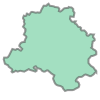

In [88]:
delhi_geom = Polygon(geometry.getInfo()['coordinates'][0])
delhi_geom

In [101]:
xds['geometry'] = list(map(Point, zip(xds['lng'], xds['lat'])))
gdf = gpd.GeoDataFrame(xds, crs='EPSG:4326', geometry='geometry')
print(f"Total of {gdf.shape[0]} points are in the dataset")
gdf.sample(2)

Total of 299484 points are in the dataset


,lat,lng,temp,geometry
95752,28.733064,77.223224,28.98,POINT (77.22322 28.73306)
264961,28.463569,77.231309,30.71,POINT (77.23131 28.46357)


In [102]:
gdf = gdf[gdf['geometry'].within(delhi_geom)]
print(f"After clipping the points, now {gdf.shape[0]} points remain in the dataset")

After clipping the points, now 171810 points remain in the dataset


## Converting to H3 spatial index

We have now temperature for each coordinate. We need to convert them to h3 spatial index for visualization

**why visualizing the data with h3 spatial index ?**

- Better compatibility with other visualization tools
- Faster visualization
- requires less space to store the data
- Performance and Scalability: H3 is designed for scalability and performance, making it suitable for real-time or dynamic visualizations of large-scale geospatial datasets

In [103]:
APERTURE_SIZE = 8
hex_col = 'hex'+str(APERTURE_SIZE)
hex_col

'hex8'

In [105]:
gdf.shape

(171810, 4)

In [106]:
# find hexs containing the points
gdf[hex_col] = gdf.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)
gdf.sample(5)

,lat,lng,temp,geometry,hex8
176632,28.603706,76.921390,33.55,POINT (76.92139 28.60371),883da189e9fffff
28597,28.839963,77.188190,27.16,POINT (77.18819 28.83996),883da1ba41fffff
218518,28.537231,77.056138,31.86,POINT (77.05614 28.53723),883da11027fffff
123164,28.689046,77.022002,31.28,POINT (77.02200 28.68905),883da18f35fffff
182251,28.594723,76.902526,34.01,POINT (76.90253 28.59472),883da1893bfffff


In [107]:
# calculate temperature average per hex
temp_hex_data = gdf.groupby(hex_col)['temp'].mean().to_frame('temp').reset_index()
temp_hex_data.sample(5)

,hex8,temp
1851,883da1b915fffff,28.594138
2042,883da1c657fffff,32.957442
2080,883da1c6cdfffff,30.957816
1185,883da1856bfffff,27.994545
1656,883da18e21fffff,29.264318


In [108]:
temp_hex_data.shape

(2100, 2)

After creating the hexagons using the h3 spatial index, the point data are reduced to 3545 from 299484.This saves a significant amount of disk space.

Also compared to geometries which are mostly having coordinates with float numbers, it is more efficient to store a h3 index as it is a string object with fixed number of characters (15-16 characters)

## Visualizing the results in pydeck

for visualizing the surface temperature data, we will first format the data


- Normalizing the temperature values
- then color coding the temperature values using a colormap
- splitting the colormap values to make it compatible with pydeck `get_fill_color` attribute
- Formatting a tooltip for interactive data visualization

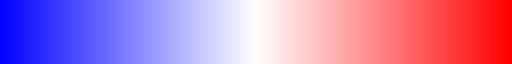

In [109]:
def color_code_value(value, cmap):
    color = cmap(value)
    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors

## Choose a colormap
cmap = colormaps['bwr']
cmap

In [110]:
xdf = temp_hex_data.copy()

## Scale the temperature values between 0-1; using MinMax Scaler
xdf['norm_temp'] = (xdf['temp']-xdf['temp'].min())/(xdf['temp'].max()-xdf['temp'].min())
xdf['color'] = xdf['norm_temp'].apply(lambda x: color_code_value(x, cmap))
xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
xdf = xdf.drop(['color', 'norm_temp'], axis=1)

## formatting the temperature value upto 1 decimal place
xdf['temp'] = xdf['temp'].round(1)

xdf.sample(4)

,hex8,temp,R,G,B,A
137,883da10233fffff,29.8,200,200,255,100
434,883da11151fffff,31.3,255,220,220,100
204,883da102dbfffff,29.3,170,170,255,100
1660,883da18e29fffff,28.5,120,120,255,100


Generating the tooltip:

In [113]:
tooltip = {
        "html": "<b>Temperature</b>: {temp} °C",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

Finally plotting the results on a 3D map

In [114]:
# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    xdf,
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagon=hex_col,
    get_fill_color="[R, G, B, A]"
)

# Set the viewport location
view_state = pdk.ViewState(latitude=28.664, longitude=77.1062, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip = tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.664,
    "longitude": 77.1062,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 255,
          "G": 238,
          "R": 238,
          "hex8": "883da10001fffff",
          "temp": 30.4
        },
        {
          "A": 100,
          "B": 246,
          "G": 246,
          "R": 255,
          "hex8": "883da10003fffff",
          "temp": 30.9
        },
        {
          "A": 100,
          "B": 254,
          "G": 254,
          "R": 255,
          "hex8": "883da10005fffff",
          "temp": 30.8
        },
        {
          "A": 100,
          "B": 226,
          "G": 226,
          "R": 255,
          "hex8": "883da10007fffff",
          "temp": 31.2
        },
        {
          "A": 100,
          "B": 255,
          "G": 208,
          "R": 208,
          "hex8": "883da10009fffff",
          "temp": 30.0
        },
        {
          "A": 100,
          "B": 255,
          "G": 250,
          "R": 250,
          "hex8": "883da1000bfffff",
          "temp": 30.6
        },
        {
          "A": 100,
          "B": 255,
          "G": 236,
          "R": 236,
          "hex8": "883da1000dfffff",
          "temp": 30.4
        },
        {
          "A": 100,
          "B": 255,
          "G": 252,
          "R": 252,
          "hex8": "883da10011fffff",
          "temp": 30.7
        },
        {
          "A": 100,
          "B": 255,
          "G": 248,
          "R": 248,
          "hex8": "883da10013fffff",
          "temp": 30.6
        },
        {
          "A": 100,
          "B": 234,
          "G": 234,
          "R": 255,
          "hex8": "883da10015fffff",
          "temp": 31.1
        },
        {
          "A": 100,
          "B": 252,
          "G": 252,
          "R": 255,
          "hex8": "883da10017fffff",
          "temp": 30.8
        },
        {
          "A": 100,
          "B": 252,
          "G": 252,
          "R": 255,
          "hex8": "883da10019fffff",
          "temp": 30.8
        },
        {
          "A": 100,
          "B": 248,
          "G": 248,
          "R": 255,
          "hex8": "883da1001bfffff",
          "temp": 30.8
        },
        {
          "A": 100,
          "B": 244,
          "G": 244,
          "R": 255,
          "hex8": "883da1001dfffff",
          "temp": 30.9
        },
        {
          "A": 100,
          "B": 210,
          "G": 210,
          "R": 255,
          "hex8": "883da10021fffff",
          "temp": 31.5
        },
        {
          "A": 100,
          "B": 222,
          "G": 222,
          "R": 255,
          "hex8": "883da10023fffff",
          "temp": 31.3
        },
        {
          "A": 100,
          "B": 195,
          "G": 195,
          "R": 255,
          "hex8": "883da10025fffff",
          "temp": 31.7
        },
        {
          "A": 100,
          "B": 200,
          "G": 200,
          "R": 255,
          "hex8": "883da10027fffff",
          "temp": 31.6
        },
        {
          "A": 100,
          "B": 246,
          "G": 246,
          "R": 255,
          "hex8": "883da10029fffff",
          "temp": 30.9
        },
        {
          "A": 100,
          "B": 220,
          "G": 220,
          "R": 255,
          "hex8": "883da1002bfffff",
          "temp": 31.3
        },
        {
          "A": 100,
          "B": 232,
          "G": 232,
          "R": 255,
          "hex8": "883da1002dfffff",
          "temp": 31.1
        },
        {
          "A": 100,
          "B": 208,
          "G": 208,
          "R": 255,
          "hex8": "883da10031fffff",
          "temp": 31.5
        },
        {
          "A": 100,
          "B": 240,
          "G": 240,
          "R": 255,
          "hex8": "883da10033fffff",
          "temp": 31.0
        },
        {
          "A": 100,
          "B": 216,
          "G": 216,
          "R": 255,
      

## Reference

1. [Create a choropleth map using h3 and plotly](https://medium.com/@ransaka/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-c65555744c87)

2. [Uber h3 py notebook](https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb)

3. [All available matplotlib colormaps for plotting](https://matplotlib.org/stable/users/explain/colors/colormaps.html)